In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Params import *
from helper_functions import *
from Solver import *
from Tail_rotor import lambda_i_tail_forward

# X-axis towards the rear of the helicopter
# Y-axis towards the right
# Z-axis towards the top
# Mx>0 if rolling is CCW as seen from the back
# My>0 if pitching is CCW as seen from the right
# Mz>0 if main rotor is CCW as seen from top
rotor["cyclic_c"]=1.59
rotor["cyclic_s"]=-3.79
rotor["collective"]=3.2
tail_rotor["collective"]=4.29

def Plot_Forward(rotor, rotor_aero, engine, flight_condition, tail_thrust=0):

    b = rotor["b"]
    #sigh = np.linspace(0, 2*np.pi, 360)  # azimuth angles for flapping
    altitude = flight_condition["altitude"]
    rho = atmosphere(altitude, delta_ISA=flight_condition["delta_ISA"])["rho"]
    R_tip  = rotor["Rt"]
    R_root = rotor["Rr"]
    C_tip = rotor["chord_tip"]
    C_root = rotor["chord_root"]
    Omega = engine["omega"]
    coll=rotor["collective"]

    a = rotor_aero["Cl_alpha"]
    V_inf = flight_condition["velocity"][0] # horizontal velocity component (w)
    drag = fuselage_drag(fuselage, rho, flight_condition["velocity"])

    if tail_thrust==0:
        TOGW = fuselage["Empty_Weight"] + payload["weight"] + flight_condition["fuel_weight"]
        theta_1c=rotor["cyclic_c"]
        theta_1s=rotor["cyclic_s"]
        alpha_tpp = alphaTPP(drag,TOGW)    #in radians

        theta_fn = lambda r,sigh: pitch_x_forward(rotor, r, sigh, theta_1c, theta_1s, coll)
        Lambda_induced_forward = lambda r, sigh: lambda_i_forward(mu, r, R_tip, sigh, alpha_tpp, Omega, rho, V_inf)
    else:
        alpha_tpp=0

        theta_fn = lambda r,sigh: tail_pitch_x_forward(rotor, r, coll)
        Lambda_induced_forward = lambda r, sigh: lambda_i_tail_forward(mu, r, R_tip, sigh, alpha_tpp, Omega, rho, V_inf, tail_thrust)


    B1c = alpha_tpp
    def B_dot(sigh):
        return -B1c*np.sin(sigh)*Omega

    B0_old = 0. ## Assuming no coning for now

    mu =  V_inf*np.cos(alpha_tpp)/ (Omega * R_tip)  # advance ratio

    # Induced velocity as a function of r,sigh
    v_fn = lambda r,sigh: induced_velocity_forward(Lambda_induced_forward(r,sigh), Omega, R_tip, V_inf,alpha_tpp)
    B_fn = lambda sigh: B0_old + B1c*np.cos(sigh)

    # Inflow angle phi as a function of r,sigh
    phi_fn = lambda r,sigh: compute_phi_forward(V_inf, v_fn(r,sigh), Omega, alpha_tpp,sigh,r,B_fn(sigh),B_dot(sigh),R_root)

    # Chord as a function of r
    c_fn = lambda r: chord_r(rotor,r)

    # Lift coefficient as a function of r
    Cl_fn = lambda r,sigh: airfoil_lift(
        Cl0=rotor_aero["Cl0"],
        Cl_alpha=rotor_aero["Cl_alpha"],
        alpha0=rotor_aero["alpha0"],
        alpha = theta_fn(r,sigh) - phi_fn(r,sigh),
        alpha_stall=rotor_aero["alpha_stall"]

    )

    # Aspect ratio estimate for drag calculation?
    AR = (R_tip - R_root) / ((C_root + C_tip) / 2)

    # Drag coefficient as a function of r
    Cd_fn = lambda r,sigh: airfoil_drag(
        Cd0=rotor_aero["Cd0"],
        Cl=Cl_fn(r,sigh),
        e=rotor_aero["e"],
        AR=AR
    )

    # Check stall across all radii (not just samples)
    # Check stall across all radii and all azimuth angles (sigh)
    r_all = np.linspace(R_root, R_tip, 100)       # dense discretization in radius
    sigh_all = np.linspace(0, 2*np.pi, 90)       # dense discretization in azimuth

    for r in r_all:
        for sigh_val in sigh_all:
            alpha = theta_fn(r, sigh_val) - phi_fn(r, sigh_val)
            if alpha > rotor_aero["alpha_stall"]:
                print(f"Stall detected in tail rotor at r = {r:.3f} m, sigh = {sigh_val:.3f} rad, alpha = {alpha:.3f} deg")
                return None,None,None,None,None,None

    # # --- Coning angle iteration ---
    if tail_thrust==0:
        tolerance = 1e-2
        max_iter = 7
        iter_count = 0

        I = rho*a*(C_tip + C_root)*R_root**4/(2*rotor["lock_number"] ) # Lock number
        while True:
            # Define coning angle function with current guess
            B_fn = lambda sigh: B0_old + B1c * np.cos(sigh)

            # Solve for new coning angle
            B0_new = Coning_Angle_Solver(
                rho=rho,
                Ut_fn=lambda r, sigh: Omega * r + V_inf*np.cos(alpha_tpp)*np.sin(sigh),
                Up_fn=lambda r, sigh: V_inf*np.sin(alpha_tpp) + v_fn(r,sigh) + r*B_dot(sigh)
                                    + V_inf*np.sin(B_fn(sigh))*np.cos(sigh),
                c_fn=c_fn, Cl_fn=Cl_fn,
                R_root=R_root, R_tip=R_tip, I=I, Omega=Omega,
                N0=50, max_iter=2, tol=1e-3
            )

            # Check convergence
            if abs(B0_new - B0_old) < tolerance:
                break

            # Update and continue
            B0_old = B0_new
            iter_count += 1
            if iter_count >= max_iter:
               # print("Warning: B0 iteration did not converge")
                break

        # Final converged value
        B0_final = B0_new
        print("Converged B0 (coning angle):", B0_final)
        B_fn = lambda sigh: B0_final + B1c*np.cos(sigh)


    # Now run the first iterative tail_thrust calculation
    res = iterative_solver_forward(
        b=b, rho=rho,
        Ut_fn=lambda r,sigh: Omega * r + V_inf*np.cos(alpha_tpp)*np.sin(sigh),
        Up_fn=lambda r,sigh: V_inf*np.sin(alpha_tpp) + v_fn(r,sigh) + r*B_dot(sigh) + V_inf*np.sin(B_fn(sigh))*np.cos(sigh),
        c_fn=c_fn, Cl_fn=Cl_fn, v_fn = v_fn,
        phi_fn=phi_fn, Cd_fn=Cd_fn,
        R_root=R_root, R_tip=R_tip,
        N0 = 25, max_iter = 4, tol=1e-3
    )

    return res["D"]+res['T'] * np.sin(alpha_tpp)+drag["Dx"],0,res['T']* np.cos(alpha_tpp),res["Mr"],res["Mp"],-res["Q"]




Fx_list_coll, Fy_list_coll, Fz_list_coll=[],[],[]
Mx_list_coll, My_list_coll, Mz_list_coll=[],[],[]

coll_init=rotor["collective"]
coll_range=np.arange(coll_init-2.5,coll_init+2.5,0.5)
for coll in coll_range:
    rotor["collective"]=coll
    Fx,Fy,Fz,Mx,My,Mz=Plot_Forward(rotor,rotor_aero,engine,flight_condition)

    Fx_list_coll.append(Fx)
    Fy_list_coll.append(Fy)
    Fz_list_coll.append(Fz)

    Mx_list_coll.append(Mx)
    My_list_coll.append(My)
    Mz_list_coll.append(Mz)
rotor["collective"]=coll_init
print("------------------------------")


Fx_list_theta1c, Fy_list_theta1c, Fz_list_theta1c=[],[],[]
Mx_list_theta1c, My_list_theta1c, Mz_list_theta1c=[],[],[]

t1c_init = rotor["cyclic_c"]
theta1c_range=np.arange(t1c_init-3,t1c_init+3,0.5)
for theta in theta1c_range:
    rotor["cyclic_c"]=theta
    Fx,Fy,Fz,Mx,My,Mz=Plot_Forward(rotor,rotor_aero,engine,flight_condition)

    Fx_list_theta1c.append(Fx)
    Fy_list_theta1c.append(Fy)
    Fz_list_theta1c.append(Fz)

    Mx_list_theta1c.append(Mx)
    My_list_theta1c.append(My)
    Mz_list_theta1c.append(Mz)
rotor["cyclic_c"]=t1c_init
print("------------------------------")


Fx_list_theta1s, Fy_list_theta1s, Fz_list_theta1s=[],[],[]
Mx_list_theta1s, My_list_theta1s, Mz_list_theta1s=[],[],[]

t1s_init=rotor["cyclic_s"]
theta1s_range=np.arange(t1s_init-3,t1s_init+3,0.5)
for theta in theta1s_range:
    rotor["cyclic_s"]=theta
    Fx,Fy,Fz,Mx,My,Mz=Plot_Forward(rotor,rotor_aero,engine,flight_condition)

    Fx_list_theta1s.append(Fx)
    Fy_list_theta1s.append(Fy)
    Fz_list_theta1s.append(Fz)

    Mx_list_theta1s.append(Mx)
    My_list_theta1s.append(My)
    Mz_list_theta1s.append(Mz)
rotor["cyclic_s"]=t1s_init
print("------------------------------")


Fx_list_tail, Fy_list_tail, Fz_list_tail=[],[],[]
Mx_list_tail, My_list_tail, Mz_list_tail=[],[],[]

tail_coll=tail_rotor["collective"]
tail_range=np.arange(tail_coll-2.5,tail_coll+2.5,0.5)
for tail_coll in tail_range:
    armlen=tail_rotor["arm_length"]
    tail_thrust=Mz_list_coll[0]/armlen
    tail_rotor["collective"]=tail_coll
    Fx,Fy,Fz,Mx,My,Mz = Plot_Forward(tail_rotor,tail_rotor_aero,engine,flight_condition,tail_thrust)

    Fx_list_tail.append(Fx)
    Fy_list_tail.append(Fz)
    Fz_list_tail.append(Fy)

    Mx_list_tail.append(Mx)
    My_list_tail.append(Mz)
    Mz_list_tail.append(My)
    
tail_coll=tail_rotor["collective"]




Converged B0 (coning angle): 0.04728777601367829
Converged B0 (coning angle): 0.056816920840707046
Converged B0 (coning angle): 0.0663481808812468
Converged B0 (coning angle): 0.07588185941283536
Converged B0 (coning angle): 0.08541825833774339
Converged B0 (coning angle): 0.09495767799908868
Converged B0 (coning angle): 0.10450041699760754
Converged B0 (coning angle): 0.11404677200854903
Converged B0 (coning angle): 0.1235970376180786
Converged B0 (coning angle): 0.13315150626853306
------------------------------
Converged B0 (coning angle): 0.09489959516869607
Converged B0 (coning angle): 0.09490927553134393
Converged B0 (coning angle): 0.09491895593762553
Converged B0 (coning angle): 0.09492863638754077
Converged B0 (coning angle): 0.09493831688108972
Converged B0 (coning angle): 0.09494799741827235
Converged B0 (coning angle): 0.09495767799908868
Converged B0 (coning angle): 0.0949673586235387
Converged B0 (coning angle): 0.09497703929162236
Converged B0 (coning angle): 0.094986720

In [2]:
import numpy as np

theta1c_range = np.arange(-t1c_init - 3, -t1c_init + 3, 0.5)

Fy_list_coll = np.array(Fy_list_coll) + Fy_list_tail[5]
Fy_list_theta1c = np.array(Fy_list_theta1c) + Fy_list_tail[5]
Fy_list_theta1s = np.array(Fy_list_theta1s) + Fy_list_tail[5]

Fx_list_tail = np.array(Fx_list_tail) + Fx_list_coll[5]
Fy_list_tail = np.array(Fy_list_tail) + Fy_list_coll[5]
Fz_list_tail = np.array(Fz_list_tail) + Fz_list_coll[5]

Mx_list_tail = np.array(Mx_list_tail) + Mx_list_coll[5]
My_list_tail = np.array(My_list_tail) + My_list_coll[5]
Mz_list_tail = np.array(Mz_list_tail) + Mz_list_coll[5]

### Standard Plots

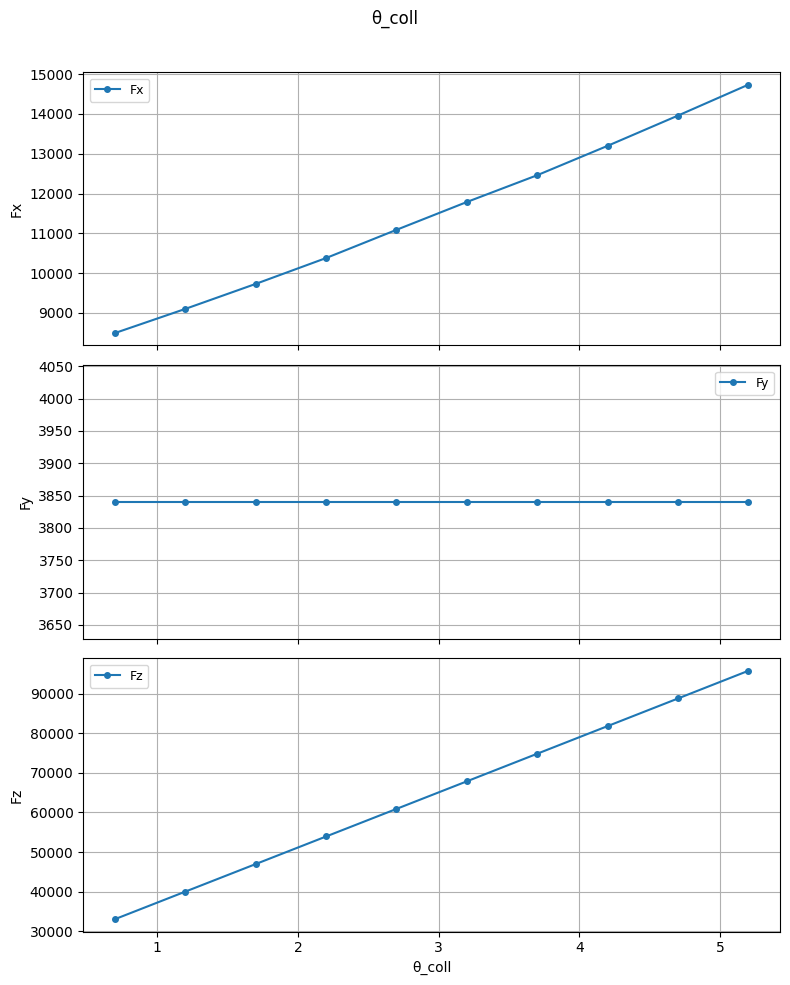

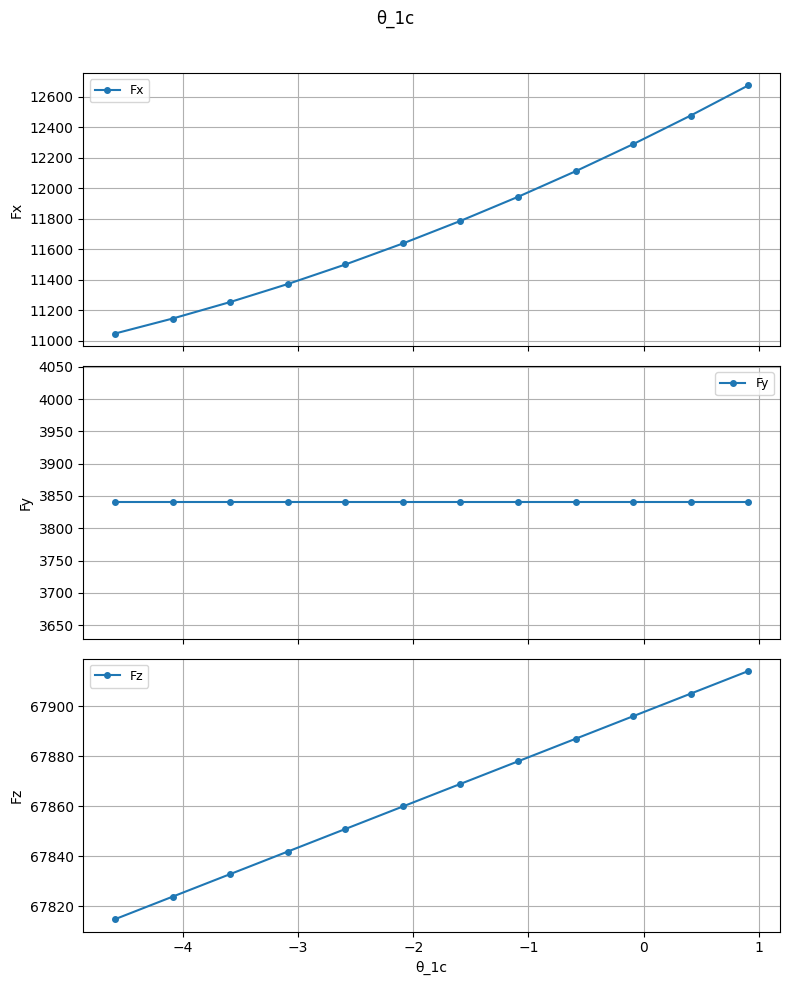

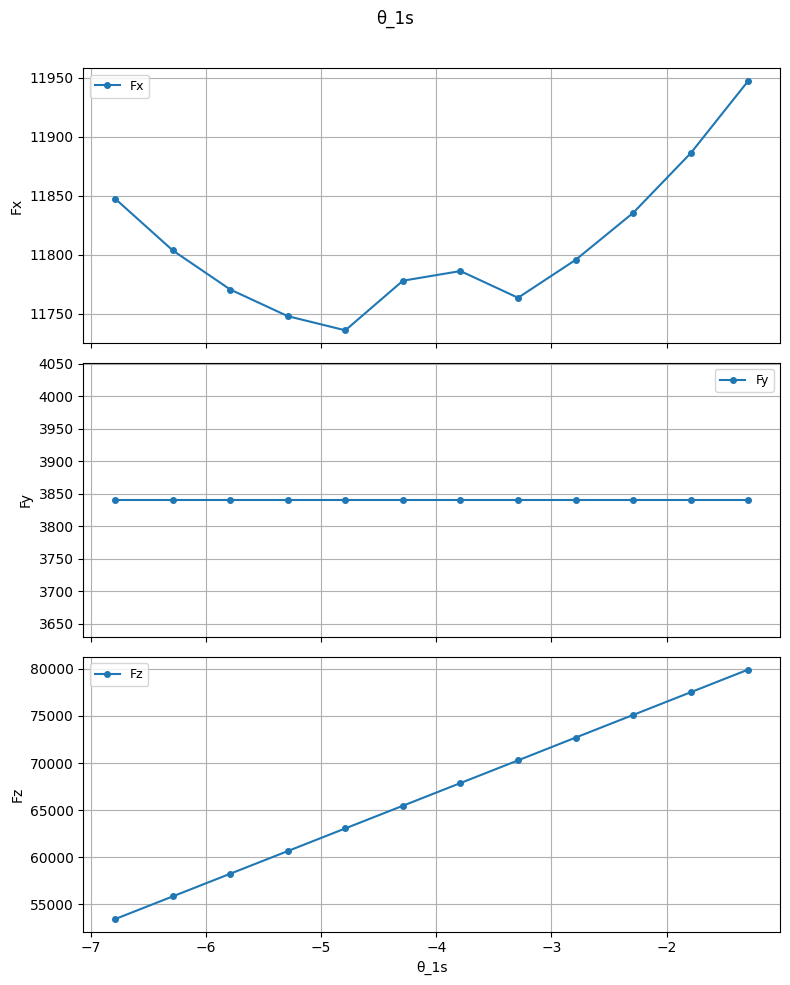

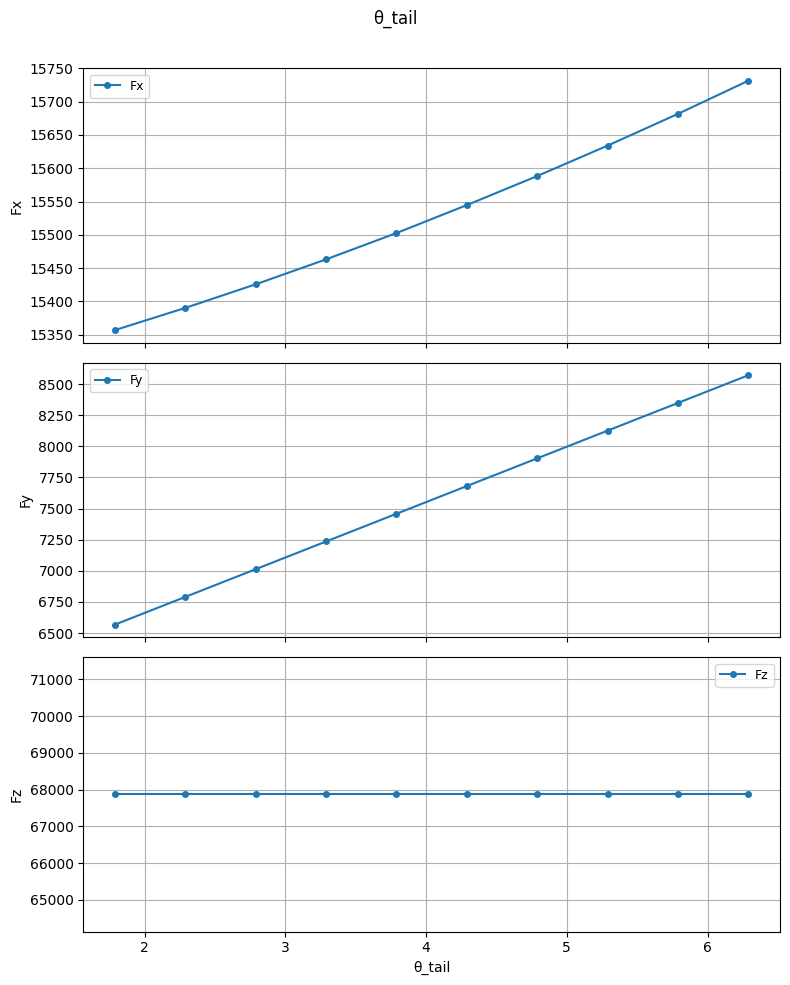

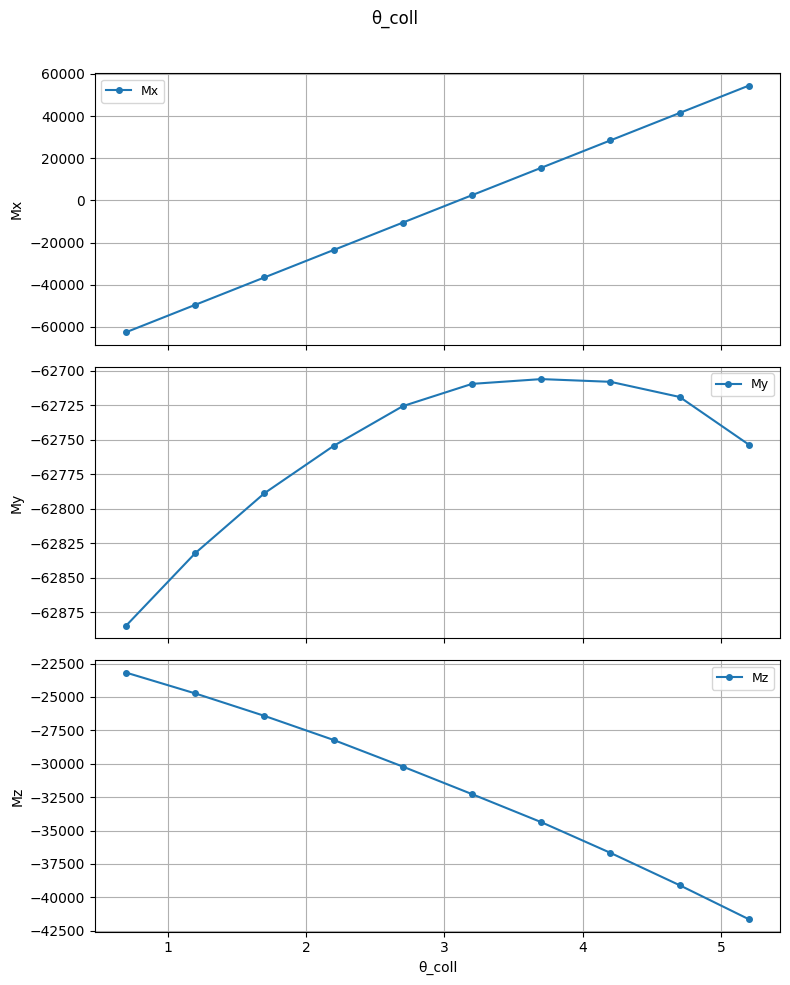

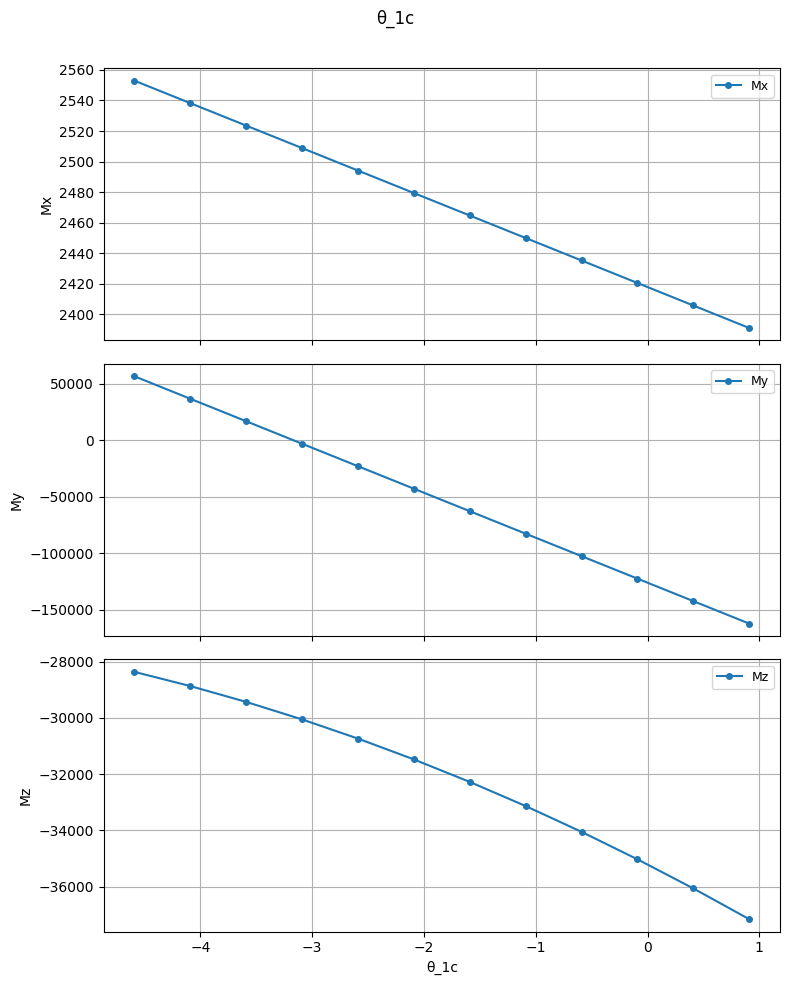

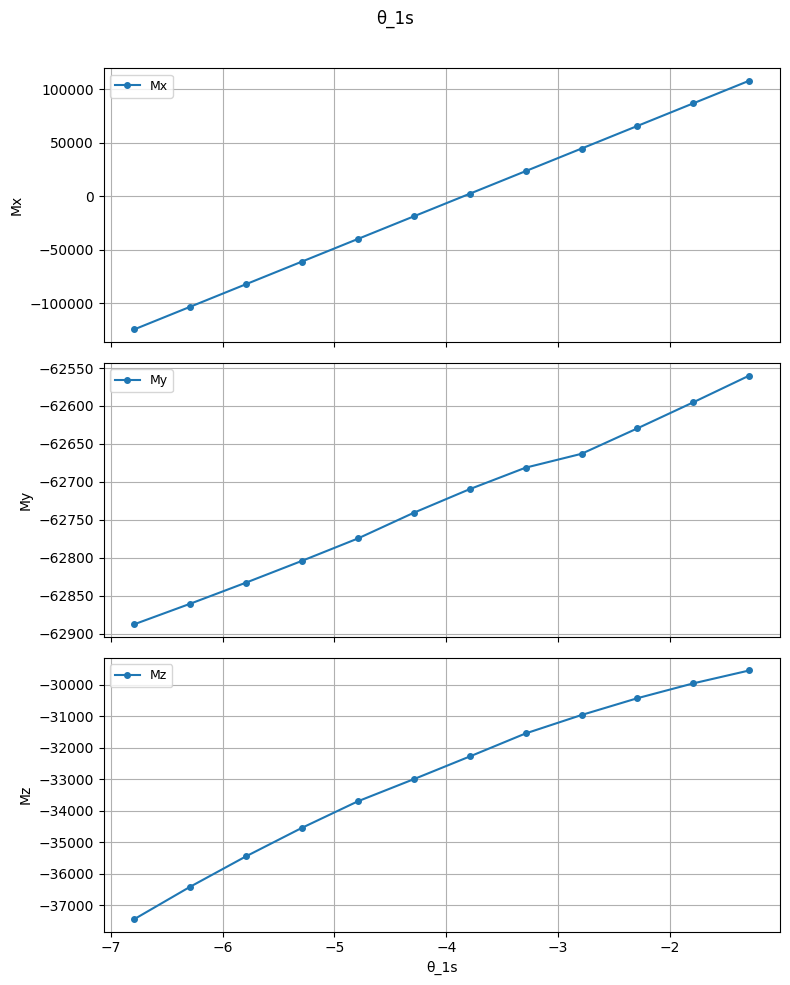

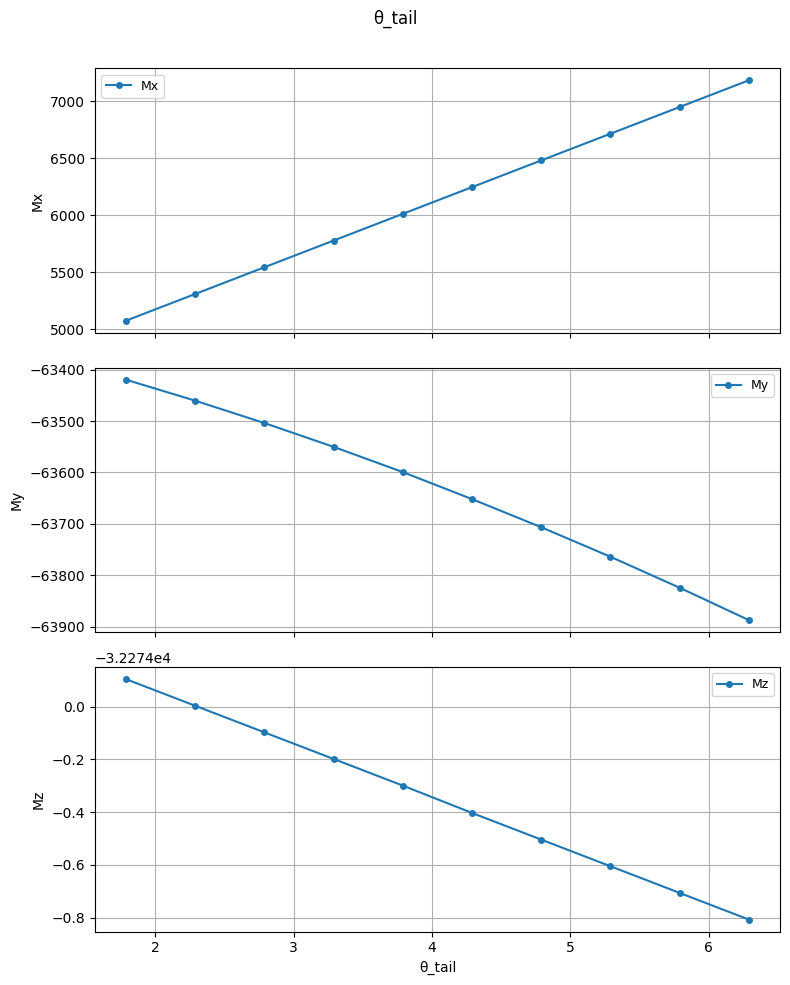

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot(x, y1, y2, y3, y_names, variable):
    ys = [y1, y2, y3]
    fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

    for i, (y, label) in enumerate(zip(ys, y_names)):
        axs[i].plot(x, y, marker='o', markersize=4, label=label)
        axs[i].set_ylabel(label)
        axs[i].grid(True)
        axs[i].legend(loc="best", fontsize=9)

    axs[-1].set_xlabel(variable)
    plt.suptitle(variable)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show(block=False)





def plot_all():
    # use globals to fetch variables dynamically

    g = globals()
    x_names=["coll","theta1c","theta1s","tail"]
    y_names=["Fx","Fy","Fz"]
    y_names2=["Mx","My","Mz"]
    for i in x_names:  # x1..x4
        x = g[f"{i}_range"]
        ys = [g[f"{j}_list_{i}"] for j in y_names]
        if i==x_names[1] or i==x_names[2]:
          plot(x, *ys, y_names, variable=f"θ_1{i[-1]}")
        else:
          plot(x, *ys, y_names, variable=f"θ_{i}",)
    
    for i in x_names:  # x1..x4
        x = g[f"{i}_range"]
        ys = [g[f"{j}_list_{i}"] for j in y_names2]
        if i==x_names[1] or i==x_names[2]:
          plot(x, *ys, y_names2, variable=f"θ_1{i[-1]}")
        else:
          plot(x, *ys, y_names2, variable=f"θ_{i}",)


plot_all()

print()

## Normalized Plots

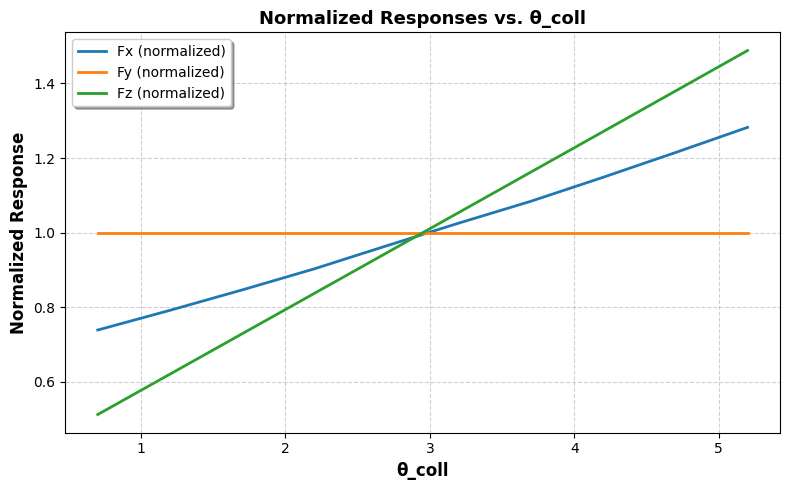

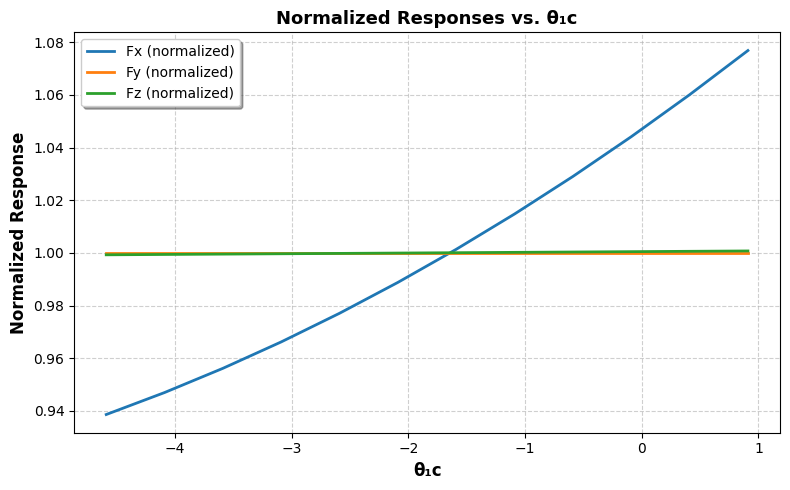

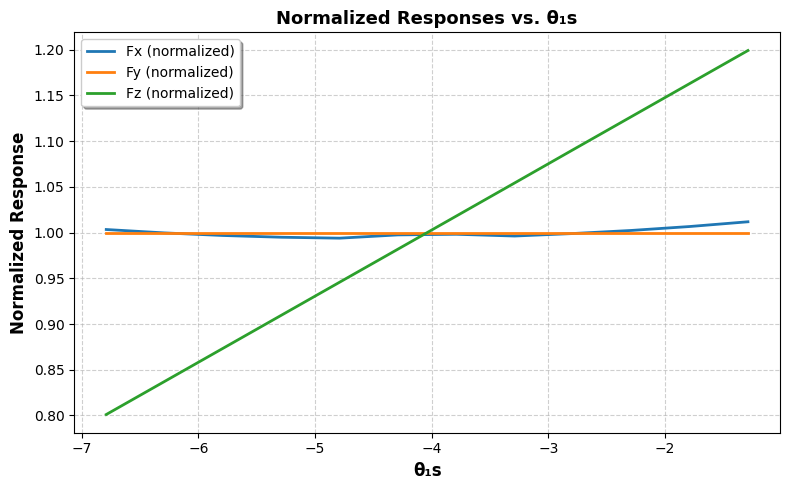

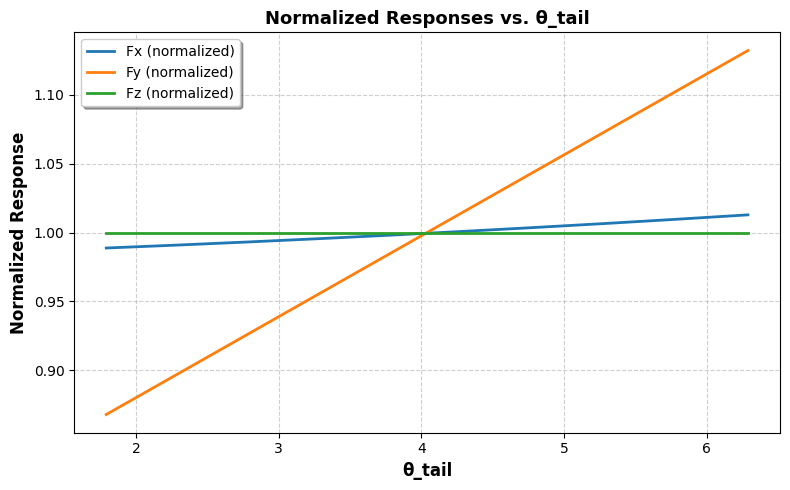

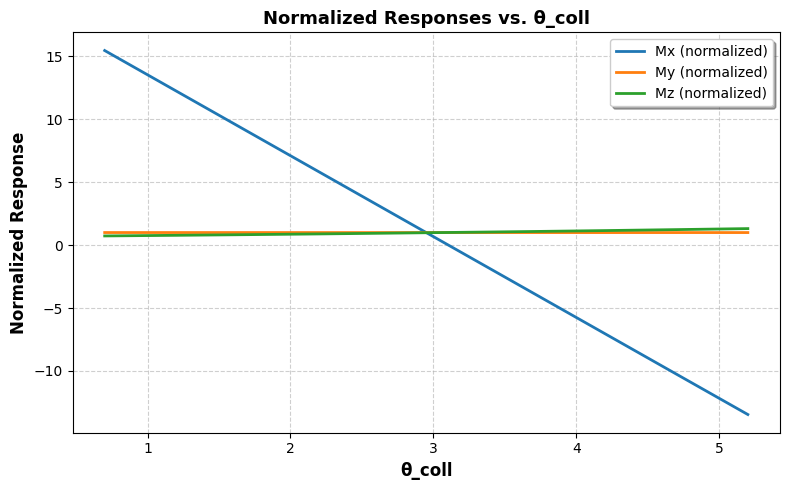

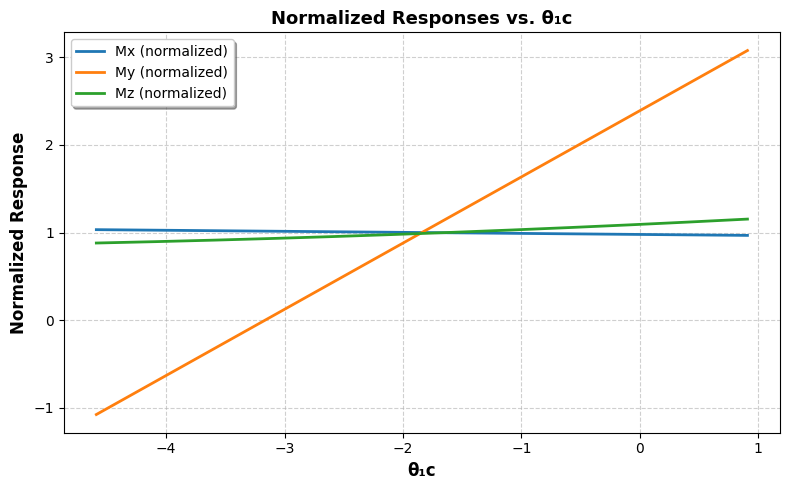

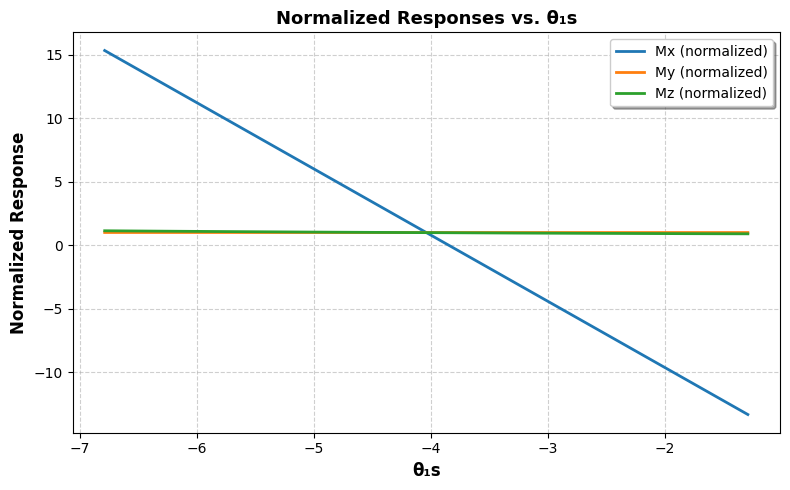

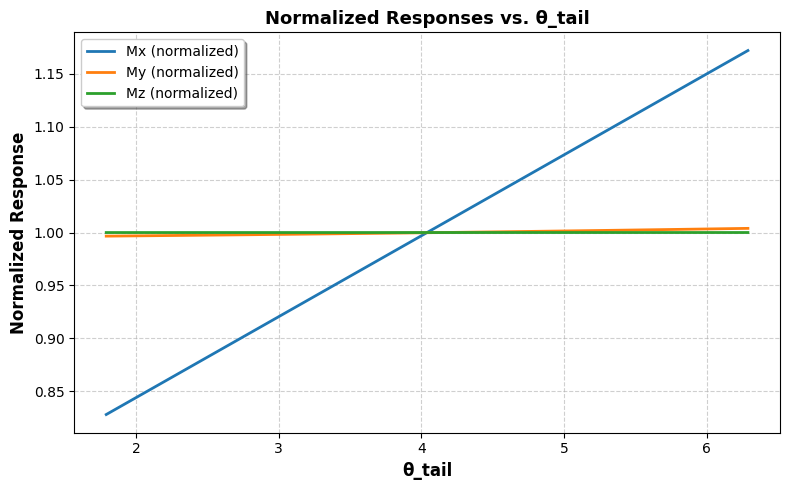

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot(x, y1, y2, y3, y_names, variable):
    """
    Normalizes the three Y datasets by their respective averages,
    then plots them all together on the same graph with a shared legend.
    """
    ys = [y1, y2, y3]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

    # --- Normalize each Y array by its mean ---
    ys_norm = []
    for y in ys:
        mean_val = np.mean(y)
        if mean_val != 0:
            ys_norm.append(y / mean_val)
        else:
            ys_norm.append(y)  # avoid division by zero

    plt.figure(figsize=(8, 5))
    for y, color, label in zip(ys_norm, colors, y_names):
        plt.plot(x, y, color=color, linewidth=2, label=f"{label} (normalized)")

    plt.xlabel(variable, fontsize=12, fontweight='bold')
    plt.ylabel("Normalized Response", fontsize=12, fontweight='bold')
    plt.title(f"Normalized Responses vs. {variable}", fontsize=13, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)
    plt.tight_layout()
    plt.show(block=False)


def plot_all():
    g = globals()
    x_names = ["coll", "theta1c", "theta1s", "tail"]
    y_names = ["Fx", "Fy", "Fz"]
    y_names2 = ["Mx", "My", "Mz"]

    # --- Forces ---
    for i in x_names:
        x = g[f"{i}_range"]
        ys = [g[f"{j}_list_{i}"] for j in y_names]
        if i in ["theta1c", "theta1s"]:
            plot(x, *ys, y_names, variable=f"θ₁{i[-1]}")
        else:
            plot(x, *ys, y_names, variable=f"θ_{i}")

    # --- Moments ---
    for i in x_names:
        x = g[f"{i}_range"]
        ys = [g[f"{j}_list_{i}"] for j in y_names2]
        if i in ["theta1c", "theta1s"]:
            plot(x, *ys, y_names2, variable=f"θ₁{i[-1]}")
        else:
            plot(x, *ys, y_names2, variable=f"θ_{i}")

# --- Run ---
plot_all()